We start with first iteration

## Target:
- Get the set-up right
- Set Transforms
- Set Data Loader
- Set Basic Working Code
- Set Basic Training & Test Loop
- Get the basic skeleton right, with 4 Convolution blocks , No maxpooling and receptive field of > 44

## Results:
- Parameters: 1,605,600
- Best Training Accuracy: 99.5%
- Best Test Accuracy: 76%

## Analysis

- Model is clearly overfitting
- Also model parameters can be reduced further

## Import Libraries

In [7]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchsummary import summary
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import torch
from torch.utils.data import DataLoader



## Check for CUDA

In [8]:
# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)
device = torch.device("cuda" if cuda else "cpu")

CUDA Available? True


## Mean and Std Deviation Computation for CIFAR-10

In [6]:
# Load CIFAR-10 without normalization
transform = transforms.ToTensor()
train_data = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_data, batch_size=512, shuffle=True)

# Get all images in one batch
data_iter = iter(train_loader)
images, _ = next(data_iter)

# Compute mean and std across channels
mean = images.mean(dim=[0, 2, 3])
std = images.std(dim=[0, 2, 3])

print("Mean:", mean)
print("Std:", std)


Mean: tensor([0.4919, 0.4829, 0.4467])
Std: tensor([0.2444, 0.2408, 0.2582])


## Load dataset

In [9]:
# Define a transform to convert PIL images to Tensors and normalize them
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4919, 0.4829, 0.4467), (0.2444, 0.2408, 0.2582))
])

# Load the training dataset, downloading it if necessary
train_data = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

# Load the test dataset, downloading it if necessary
test_data = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

In [12]:
batch_size = 512

kwargs = {'batch_size': batch_size, 'shuffle': True, 'num_workers': 2, 'pin_memory': True}

test_loader = torch.utils.data.DataLoader(test_data, **kwargs)
train_loader = torch.utils.data.DataLoader(train_data, **kwargs)

## Analyse dataset

/tmp/ipykernel_36/2980208871.py:12: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


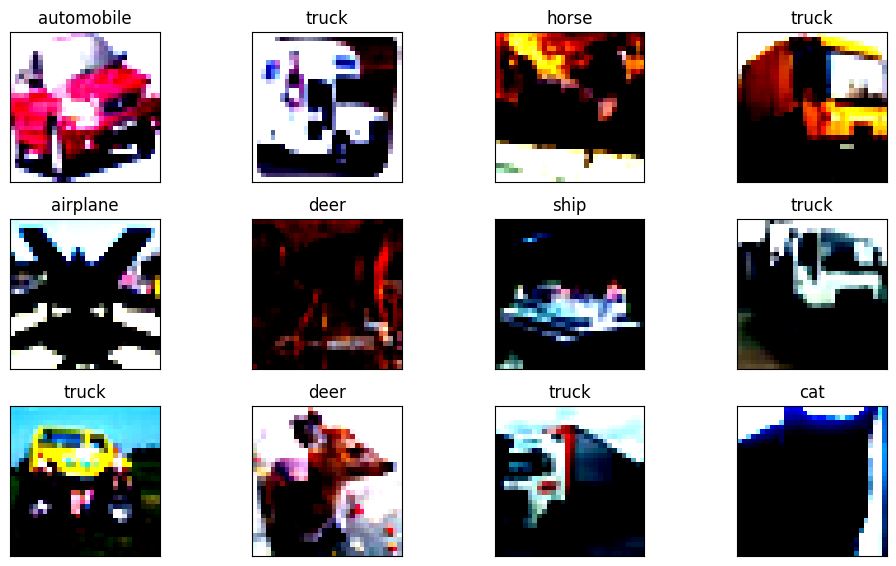

In [13]:

# Assuming batch_data is of shape [B, C, H, W] and batch_label contains class indices
fig = plt.figure(figsize=(10, 6))

# CIFAR-10 class names
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
          'dog', 'frog', 'horse', 'ship', 'truck']
batch_data, batch_label = next(iter(train_loader))


for i in range(12):
    plt.subplot(3, 4, i + 1)
    plt.tight_layout()
    plt.imshow(batch_data[i].permute(1, 2, 0))  # Convert from [C, H, W] to [H, W, C]
    plt.title(classes[batch_label[i]])
    plt.xticks([])
    plt.yticks([])

plt.show()

## Model Architecture 

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CIFAR10CustomNet(nn.Module):
    def __init__(self):
        super(CIFAR10CustomNet, self).__init__()
        self.drop_prob = 0.01

        # Block 1: 32x32 -> 16x16
        self.block1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),  # RF: 3
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Dropout(self.drop_prob),
            nn.Conv2d(32, 32, kernel_size=3, stride=2, padding=1),  # RF: 7
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Dropout(self.drop_prob)
        )

        # Transition to 64 channels
        self.trans1 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )

        # Block 2: 16x16 -> 8x8
        self.block2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),  # RF: 11
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(self.drop_prob),
            nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1),  # RF: 19
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(self.drop_prob)
        )

        # Transition to 128 channels
        self.trans2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )

        # Block 3: 8x8 -> 4x4
        self.block3 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),  # RF: 23
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(self.drop_prob),
            nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=1),  # RF: 35
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(self.drop_prob)
        )

        # Transition to 256 channels
        self.trans3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )

        # Block 4: 4x4 -> 2x2
        self.block4 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),  # RF: 39
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Dropout(self.drop_prob),
            nn.Conv2d(256, 256, kernel_size=3, stride=2, padding=1),  # RF: 61
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Dropout(self.drop_prob)
        )

        # GAP + FC
        self.gap = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(256, 10)

    def forward(self, x):
        x = self.block1(x)
        x = self.trans1(x)
        x = self.block2(x)
        x = self.trans2(x)
        x = self.block3(x)
        x = self.trans3(x)
        x = self.block4(x)
        x = self.gap(x)
        x = x.view(x.size(0), -1)
        return F.log_softmax(x, dim=1)


In [15]:
model = CIFAR10CustomNet().to(device)
summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
       BatchNorm2d-2           [-1, 32, 32, 32]              64
              ReLU-3           [-1, 32, 32, 32]               0
           Dropout-4           [-1, 32, 32, 32]               0
            Conv2d-5           [-1, 32, 16, 16]           9,248
       BatchNorm2d-6           [-1, 32, 16, 16]              64
              ReLU-7           [-1, 32, 16, 16]               0
           Dropout-8           [-1, 32, 16, 16]               0
            Conv2d-9           [-1, 64, 16, 16]           2,112
      BatchNorm2d-10           [-1, 64, 16, 16]             128
             ReLU-11           [-1, 64, 16, 16]               0
           Conv2d-12           [-1, 64, 16, 16]          36,928
      BatchNorm2d-13           [-1, 64, 16, 16]             128
             ReLU-14           [-1, 64,

In [16]:
print(model)

CIFAR10CustomNet(
  (block1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.01, inplace=False)
    (4): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.01, inplace=False)
  )
  (trans1): Sequential(
    (0): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (block2): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.01, inplace=False)
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    

## Train and test Loop

In [18]:
# Data to plot accuracy and loss graphs
train_losses = []
test_losses = []
train_acc = []
test_acc = []

test_incorrect_pred = {'images': [], 'ground_truths': [], 'predicted_vals': []}

def train(model, device, train_loader, optimizer, epoch):
    model.train()
    loss = 0
    correct = 0
    processed = 0
    pbar = tqdm(train_loader)
    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)
        pbar.set_description(desc= f'Train loss={loss.item():0.4f} batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)
    train_losses.append(loss/len(train_loader))

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_acc.append(100. * correct / len(test_loader.dataset))
    test_losses.append(test_loss)

    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

## Model Training

In [19]:
model = CIFAR10CustomNet().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1)
#scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=15, eta_min=0.0005)

# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.5)

# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1)
num_epochs = 20

for epoch in range(1, num_epochs+1):
    print(f'Epoch {epoch}')
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)
    scheduler.step()

Epoch 1


Train loss=2.5988 batch_id=97 Accuracy=37.65: 100%|██████████| 98/98 [00:07<00:00, 13.67it/s]


Test set: Average loss: 3.0375, Accuracy: 5039/10000 (50.39%)

Epoch 2


Train loss=1.6525 batch_id=97 Accuracy=58.27: 100%|██████████| 98/98 [00:06<00:00, 14.41it/s]


Test set: Average loss: 1.9509, Accuracy: 5734/10000 (57.34%)

Epoch 3


Train loss=1.1848 batch_id=97 Accuracy=67.02: 100%|██████████| 98/98 [00:07<00:00, 13.83it/s]


Test set: Average loss: 1.3797, Accuracy: 6451/10000 (64.51%)

Epoch 4


Train loss=0.9710 batch_id=97 Accuracy=72.78: 100%|██████████| 98/98 [00:06<00:00, 14.05it/s]


Test set: Average loss: 1.2352, Accuracy: 6632/10000 (66.32%)

Epoch 5


Train loss=0.6376 batch_id=97 Accuracy=77.25: 100%|██████████| 98/98 [00:07<00:00, 13.99it/s]


Test set: Average loss: 1.1436, Accuracy: 6825/10000 (68.25%)

Epoch 6


Train loss=0.6502 batch_id=97 Accuracy=81.50: 100%|██████████| 98/98 [00:06<00:00, 14.20it/s]


Test set: Average loss: 1.0512, Accuracy: 7010/10000 (70.10%)

Epoch 7


Train loss=0.4657 batch_id=97 Accuracy=84.40: 100%|██████████| 98/98 [00:06<00:00, 14.07it/s]


Test set: Average loss: 1.0166, Accuracy: 7127/10000 (71.27%)

Epoch 8


Train loss=0.5259 batch_id=97 Accuracy=87.56: 100%|██████████| 98/98 [00:07<00:00, 13.83it/s]


Test set: Average loss: 1.1068, Accuracy: 6987/10000 (69.87%)

Epoch 9


Train loss=0.3167 batch_id=97 Accuracy=90.38: 100%|██████████| 98/98 [00:06<00:00, 14.32it/s]


Test set: Average loss: 1.0787, Accuracy: 7110/10000 (71.10%)

Epoch 10


Train loss=0.2607 batch_id=97 Accuracy=92.85: 100%|██████████| 98/98 [00:07<00:00, 13.79it/s]


Test set: Average loss: 1.0083, Accuracy: 7294/10000 (72.94%)

Epoch 11


Train loss=0.2117 batch_id=97 Accuracy=94.90: 100%|██████████| 98/98 [00:06<00:00, 14.12it/s]


Test set: Average loss: 1.0410, Accuracy: 7347/10000 (73.47%)

Epoch 12


Train loss=0.1553 batch_id=97 Accuracy=96.40: 100%|██████████| 98/98 [00:07<00:00, 13.50it/s]


Test set: Average loss: 1.0024, Accuracy: 7489/10000 (74.89%)

Epoch 13


Train loss=0.1331 batch_id=97 Accuracy=97.43: 100%|██████████| 98/98 [00:07<00:00, 13.28it/s]


Test set: Average loss: 1.0832, Accuracy: 7332/10000 (73.32%)

Epoch 14


Train loss=0.0964 batch_id=97 Accuracy=97.98: 100%|██████████| 98/98 [00:07<00:00, 13.12it/s]


Test set: Average loss: 1.0019, Accuracy: 7522/10000 (75.22%)

Epoch 15


Train loss=0.0645 batch_id=97 Accuracy=98.50: 100%|██████████| 98/98 [00:07<00:00, 12.68it/s]


Test set: Average loss: 1.0482, Accuracy: 7421/10000 (74.21%)

Epoch 16


Train loss=0.0303 batch_id=97 Accuracy=99.50: 100%|██████████| 98/98 [00:07<00:00, 12.91it/s]


Test set: Average loss: 0.9633, Accuracy: 7669/10000 (76.69%)

Epoch 17


Train loss=0.0272 batch_id=97 Accuracy=99.71: 100%|██████████| 98/98 [00:07<00:00, 13.59it/s]


Test set: Average loss: 0.9612, Accuracy: 7654/10000 (76.54%)

Epoch 18


Train loss=0.0270 batch_id=97 Accuracy=99.80: 100%|██████████| 98/98 [00:07<00:00, 13.55it/s]


Test set: Average loss: 0.9601, Accuracy: 7672/10000 (76.72%)

Epoch 19


Train loss=0.0275 batch_id=97 Accuracy=99.83: 100%|██████████| 98/98 [00:07<00:00, 13.53it/s]


Test set: Average loss: 0.9640, Accuracy: 7671/10000 (76.71%)

Epoch 20


Train loss=0.0287 batch_id=97 Accuracy=99.86: 100%|██████████| 98/98 [00:07<00:00, 13.63it/s]


Test set: Average loss: 0.9621, Accuracy: 7677/10000 (76.77%)



## Misclassifications

In [20]:
import matplotlib.pyplot as plt

def get_misclassified(model, loader, device):
    model.eval()
    misclassified = []
    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True)

            # compare predicted vs actual
            wrong_idx = pred.squeeze().ne(target).nonzero(as_tuple=True)[0]

            for idx in wrong_idx:
                misclassified.append((data[idx].cpu(), pred[idx].item(), target[idx].item()))
    return misclassified

In [21]:
def plot_misclassified(misclassified, n=25):
    plt.figure(figsize=(10,10))
    for i, (img, pred, true) in enumerate(misclassified[:n]):
        plt.subplot(5,5,i+1)
        plt.imshow(img.permute(1, 2, 0), cmap="gray")
        plt.title(f"P:{classes[pred]}, T:{classes[true]}")
        plt.axis("off")
    plt.show()


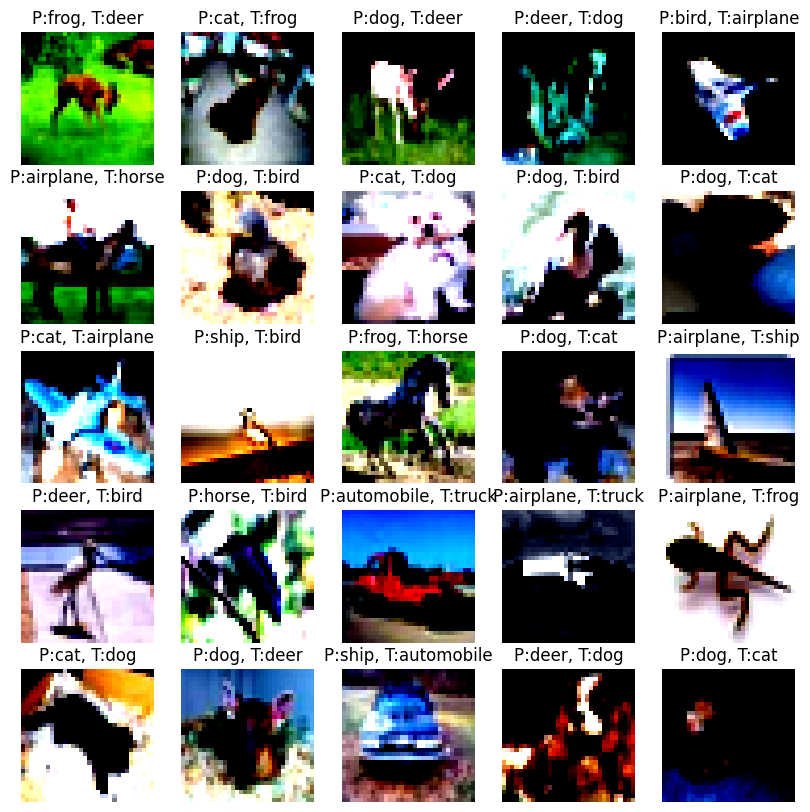

In [22]:
misclassified = get_misclassified(model, test_loader, device)
plot_misclassified(misclassified, n=25)

## Train and Test Loss

Text(0.5, 1.0, 'Test Accuracy')

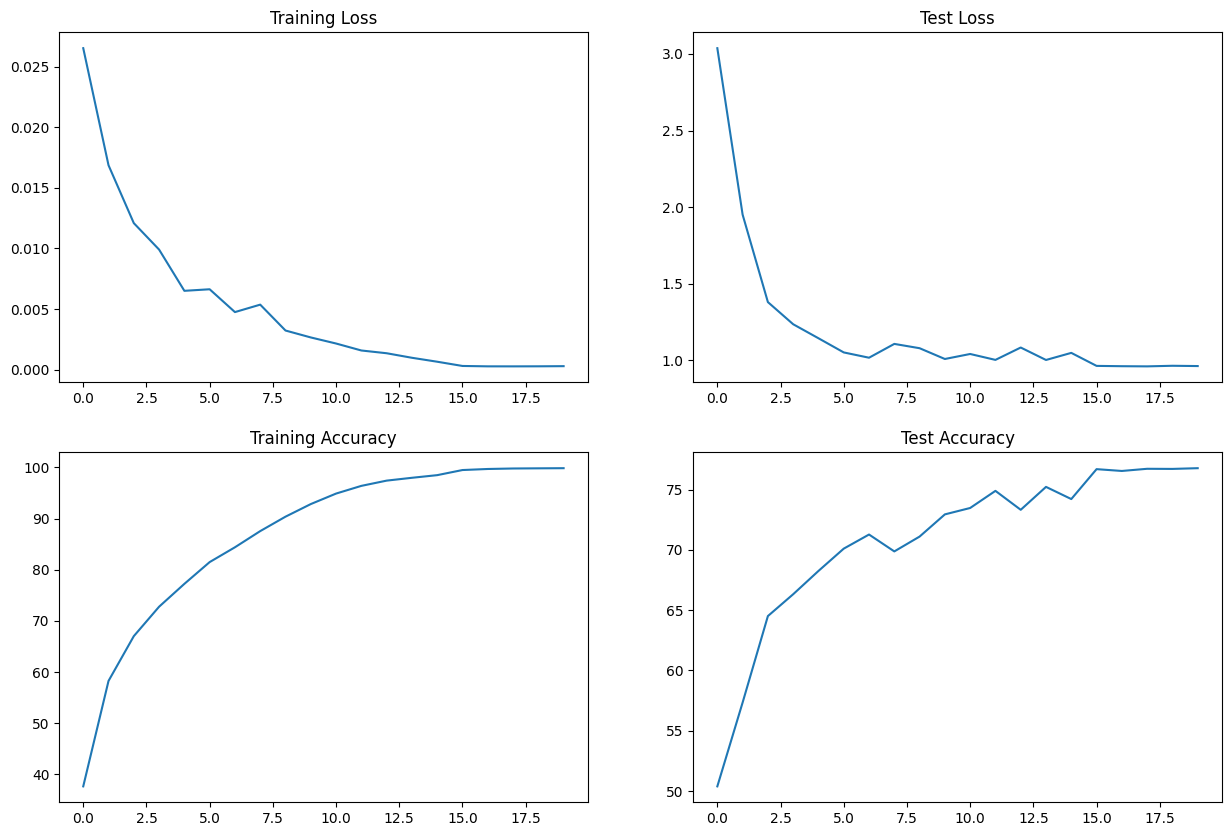

In [23]:
t = [t_items.item() for t_items in train_losses]
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(t)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")